In [1]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [2]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=1
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [3]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [4]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [5]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [6]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [7]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [8]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [9]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [10]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [11]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [12]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [13]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


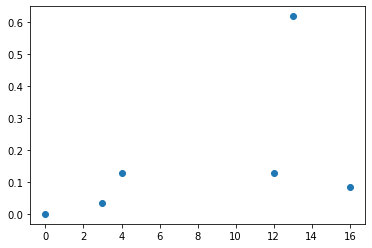

In [14]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [15]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [16]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [17]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        

    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()


In [18]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()




In [19]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [20]:
print(np.allclose(np.identity(basis.Ns),exp_gate(0,np.pi/3).conj().T@exp_gate(0,np.pi/3),atol = 1e-8,rtol= 1e-8))

True


/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [21]:
def R(i,theta):
    
    if i%9 == 0:
        return(exp_gate(0,theta))

    if i%9 == 1:
        return(exp_gate(1,theta))

    if i%9 == 2:
        return(exp_gate(2,theta))

    
    if i%9 == 3:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%9 == 4:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%9 == 5:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%9 == 6:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%9 == 7:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%9 == 8:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
        

def S(i,theta):
    
    if i%9 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%9 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%9 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())
     
    if i%9 == 3:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%9 == 4:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%9 == 5:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%9 == 6:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%9 == 7:
        return(-1j*sigma_r(0,2,0).toarray())
    

    if i%9 == 8:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())

In [22]:
coeff = 9
stepp = 1000
t_final = 10

In [23]:
matr = full_ham_matrix.toarray()
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

In [24]:
def rhs(t,theta):
    
    print(datetime.datetime.now())
    for k in range(coeff*N):
        B[k] = R(k,theta[k])
        
    psi_b = psi_0
    for k in range(coeff*N):
        psi_b = B[coeff*N-1-k]@psi_b
        
    psi_conj_b = np.conj(psi_b)

    print("start",datetime.datetime.now())
    
    for k in range(coeff*N):
        B[k] = S(k,theta[k])@R(k,theta[k])
        psi_d[k] = psi_0
        for i in range(coeff*N):
            psi_d[k] = B[coeff*N-1-i]@psi_d[k]
        B[k] = R(k,theta[k])
        
    print("stop_reduce",datetime.datetime.now())
    
    psi_conj_d = np.conj(psi_d)
    


    
    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)


    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [25]:
time_domain = np.linspace(0, t_final, stepp)


In [26]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [27]:
#start_point = 0.001*np.ones(coeff*N)
expt_value = []
energyy = []

for kkk in range(1):
    Y = []
    start_point = np.random.rand(coeff*N)
    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])

        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-11 15:42:16.570109
start 2022-08-11 15:42:16.615691
stop_reduce 2022-08-11 15:42:16.751244
2022-08-11 15:42:16.751771
0
2022-08-11 15:42:16.751810
start 2022-08-11 15:42:16.801281
stop_reduce 2022-08-11 15:42:16.921593
2022-08-11 15:42:16.922186
0.005
2022-08-11 15:42:16.922231
start 2022-08-11 15:42:16.963675
stop_reduce 2022-08-11 15:42:17.086276
2022-08-11 15:42:17.086935
0.005
2022-08-11 15:42:17.087114
start 2022-08-11 15:42:17.128256
stop_reduce 2022-08-11 15:42:17.247402
2022-08-11 15:42:17.247802
0.01
2022-08-11 15:42:17.247843
start 2022-08-11 15:42:17.289538
stop_reduce 2022-08-11 15:42:17.417285
2022-08-11 15:42:17.417948
0.01
2022-08-11 15:42:17.418128
start 2022-08-11 15:42:17.459578
stop_reduce 2022-08-11 15:42:17.582810
2022-08-11 15:42:17.583469
0.015
2022-08-11 15:42:17.583517
start 2022-08-11 15:42:17.626546
stop_reduce 2022-08-11 15:42:17.745726
2022-08-11 15:42:17.746223
0.015
2022-08-11 15:42:17.746329
start 2022-08-11 15:42:17.788930
stop_reduce 2022-08-11

start 2022-08-11 15:42:27.140839
stop_reduce 2022-08-11 15:42:27.278713
2022-08-11 15:42:27.279415
0.155
2022-08-11 15:42:27.279467
start 2022-08-11 15:42:27.328019
stop_reduce 2022-08-11 15:42:27.460187
2022-08-11 15:42:27.460831
0.155
2022-08-11 15:42:27.460882
start 2022-08-11 15:42:27.502062
stop_reduce 2022-08-11 15:42:27.620735
2022-08-11 15:42:27.621160
0.16
2022-08-11 15:42:27.621202
start 2022-08-11 15:42:27.665080
stop_reduce 2022-08-11 15:42:27.802318
2022-08-11 15:42:27.802932
0.16
2022-08-11 15:42:27.802982
start 2022-08-11 15:42:27.847920
stop_reduce 2022-08-11 15:42:27.969183
2022-08-11 15:42:27.969848
0.165
2022-08-11 15:42:27.969974
start 2022-08-11 15:42:28.011147
stop_reduce 2022-08-11 15:42:28.139468
2022-08-11 15:42:28.140013
0.165
2022-08-11 15:42:28.140055
start 2022-08-11 15:42:28.191580
stop_reduce 2022-08-11 15:42:28.324167
2022-08-11 15:42:28.324718
0.17
2022-08-11 15:42:28.324770
start 2022-08-11 15:42:28.367886
stop_reduce 2022-08-11 15:42:28.514275
2022-08

start 2022-08-11 15:42:38.002535
stop_reduce 2022-08-11 15:42:38.130708
2022-08-11 15:42:38.131324
0.3000000000000001
2022-08-11 15:42:38.131372
start 2022-08-11 15:42:38.173975
stop_reduce 2022-08-11 15:42:38.313107
2022-08-11 15:42:38.313721
0.3000000000000001
2022-08-11 15:42:38.314005
start 2022-08-11 15:42:38.369792
stop_reduce 2022-08-11 15:42:38.501720
2022-08-11 15:42:38.502187
0.3050000000000001
2022-08-11 15:42:38.502246
start 2022-08-11 15:42:38.550387
stop_reduce 2022-08-11 15:42:38.709276
2022-08-11 15:42:38.709822
0.3050000000000001
2022-08-11 15:42:38.709884
start 2022-08-11 15:42:38.762323
stop_reduce 2022-08-11 15:42:38.914794
2022-08-11 15:42:38.915426
0.3100000000000001
2022-08-11 15:42:38.915480
start 2022-08-11 15:42:38.969628
stop_reduce 2022-08-11 15:42:39.123625
2022-08-11 15:42:39.123995
0.3100000000000001
2022-08-11 15:42:39.124040
start 2022-08-11 15:42:39.179098
stop_reduce 2022-08-11 15:42:39.332577
2022-08-11 15:42:39.333091
0.3150000000000001
2022-08-11 1

start 2022-08-11 15:42:48.771488
stop_reduce 2022-08-11 15:42:48.894901
2022-08-11 15:42:48.895539
0.44500000000000023
2022-08-11 15:42:48.895722
start 2022-08-11 15:42:48.936837
stop_reduce 2022-08-11 15:42:49.058496
2022-08-11 15:42:49.059188
0.44500000000000023
2022-08-11 15:42:49.059241
start 2022-08-11 15:42:49.100597
stop_reduce 2022-08-11 15:42:49.219319
2022-08-11 15:42:49.219851
0.45000000000000023
2022-08-11 15:42:49.219902
start 2022-08-11 15:42:49.262740
stop_reduce 2022-08-11 15:42:49.384800
2022-08-11 15:42:49.385411
0.45000000000000023
2022-08-11 15:42:49.385458
start 2022-08-11 15:42:49.426826
stop_reduce 2022-08-11 15:42:49.548299
2022-08-11 15:42:49.548983
0.45500000000000024
2022-08-11 15:42:49.549163
start 2022-08-11 15:42:49.590698
stop_reduce 2022-08-11 15:42:49.709722
2022-08-11 15:42:49.710294
0.45500000000000024
2022-08-11 15:42:49.710346
start 2022-08-11 15:42:49.752630
stop_reduce 2022-08-11 15:42:49.903689
2022-08-11 15:42:49.904208
0.46000000000000024
2022-

start 2022-08-11 15:43:00.202326
stop_reduce 2022-08-11 15:43:00.335959
2022-08-11 15:43:00.336627
0.5850000000000003
2022-08-11 15:43:00.336671
start 2022-08-11 15:43:00.383178
stop_reduce 2022-08-11 15:43:00.509466
2022-08-11 15:43:00.509996
0.5900000000000003
2022-08-11 15:43:00.510056
start 2022-08-11 15:43:00.552243
stop_reduce 2022-08-11 15:43:00.674403
2022-08-11 15:43:00.674925
0.5900000000000003
2022-08-11 15:43:00.675095
start 2022-08-11 15:43:00.718069
stop_reduce 2022-08-11 15:43:00.845265
2022-08-11 15:43:00.846038
0.5950000000000003
2022-08-11 15:43:00.846149
start 2022-08-11 15:43:00.898900
stop_reduce 2022-08-11 15:43:01.049431
2022-08-11 15:43:01.050023
0.5950000000000003
2022-08-11 15:43:01.050077
start 2022-08-11 15:43:01.097298
stop_reduce 2022-08-11 15:43:01.225176
2022-08-11 15:43:01.225690
0.6000000000000003
2022-08-11 15:43:01.225806
start 2022-08-11 15:43:01.271185
stop_reduce 2022-08-11 15:43:01.451226
2022-08-11 15:43:01.452039
0.6000000000000003
2022-08-11 1

start 2022-08-11 15:43:12.137567
stop_reduce 2022-08-11 15:43:12.322139
2022-08-11 15:43:12.322909
0.7300000000000004
2022-08-11 15:43:12.322998
start 2022-08-11 15:43:12.387775
stop_reduce 2022-08-11 15:43:12.572790
2022-08-11 15:43:12.573506
0.7300000000000004
2022-08-11 15:43:12.573575
start 2022-08-11 15:43:12.637325
stop_reduce 2022-08-11 15:43:12.821271
2022-08-11 15:43:12.821979
0.7350000000000004
2022-08-11 15:43:12.822054
start 2022-08-11 15:43:12.889598
stop_reduce 2022-08-11 15:43:13.073498
2022-08-11 15:43:13.074223
0.7350000000000004
2022-08-11 15:43:13.074292
start 2022-08-11 15:43:13.138296
stop_reduce 2022-08-11 15:43:13.322425
2022-08-11 15:43:13.323184
0.7400000000000004
2022-08-11 15:43:13.323267
start 2022-08-11 15:43:13.386735
stop_reduce 2022-08-11 15:43:13.570908
2022-08-11 15:43:13.571627
0.7400000000000004
2022-08-11 15:43:13.571704
start 2022-08-11 15:43:13.636432
stop_reduce 2022-08-11 15:43:13.820238
2022-08-11 15:43:13.821031
0.7450000000000004
2022-08-11 1

stop_reduce 2022-08-11 15:43:23.908652
2022-08-11 15:43:23.909172
0.8700000000000006
2022-08-11 15:43:23.909229
start 2022-08-11 15:43:23.956325
stop_reduce 2022-08-11 15:43:24.082020
2022-08-11 15:43:24.082461
0.8750000000000006
2022-08-11 15:43:24.082520
start 2022-08-11 15:43:24.129721
stop_reduce 2022-08-11 15:43:24.258003
2022-08-11 15:43:24.258460
0.8750000000000006
2022-08-11 15:43:24.258519
start 2022-08-11 15:43:24.301768
stop_reduce 2022-08-11 15:43:24.423978
2022-08-11 15:43:24.424480
0.8800000000000006
2022-08-11 15:43:24.424635
start 2022-08-11 15:43:24.467142
stop_reduce 2022-08-11 15:43:24.587606
2022-08-11 15:43:24.588052
0.8800000000000006
2022-08-11 15:43:24.588197
start 2022-08-11 15:43:24.632317
stop_reduce 2022-08-11 15:43:24.758116
2022-08-11 15:43:24.758872
0.8850000000000006
2022-08-11 15:43:24.758950
start 2022-08-11 15:43:24.812944
stop_reduce 2022-08-11 15:43:24.969383
2022-08-11 15:43:24.970035
0.8850000000000006
2022-08-11 15:43:24.970088
start 2022-08-11 1

stop_reduce 2022-08-11 15:43:36.669108
2022-08-11 15:43:36.669741
1.0150000000000006
2022-08-11 15:43:36.669791
start 2022-08-11 15:43:36.723339
stop_reduce 2022-08-11 15:43:36.877453
2022-08-11 15:43:36.878710
1.0150000000000006
2022-08-11 15:43:36.878775
start 2022-08-11 15:43:36.934919
stop_reduce 2022-08-11 15:43:37.090548
2022-08-11 15:43:37.091237
1.0200000000000007
2022-08-11 15:43:37.091294
start 2022-08-11 15:43:37.144569
stop_reduce 2022-08-11 15:43:37.298864
2022-08-11 15:43:37.299626
1.0200000000000007
2022-08-11 15:43:37.299705
start 2022-08-11 15:43:37.355366
stop_reduce 2022-08-11 15:43:37.510161
2022-08-11 15:43:37.510793
1.0250000000000006
2022-08-11 15:43:37.510839
start 2022-08-11 15:43:37.564364
stop_reduce 2022-08-11 15:43:37.717630
2022-08-11 15:43:37.718288
1.0250000000000006
2022-08-11 15:43:37.718335
start 2022-08-11 15:43:37.771679
stop_reduce 2022-08-11 15:43:37.925062
2022-08-11 15:43:37.925665
1.0300000000000007
2022-08-11 15:43:37.925721
start 2022-08-11 1

stop_reduce 2022-08-11 15:43:49.901517
2022-08-11 15:43:49.902281
1.1550000000000007
2022-08-11 15:43:49.902352
start 2022-08-11 15:43:49.956563
stop_reduce 2022-08-11 15:43:50.112418
2022-08-11 15:43:50.113111
1.1600000000000008
2022-08-11 15:43:50.113173
start 2022-08-11 15:43:50.168107
stop_reduce 2022-08-11 15:43:50.324989
2022-08-11 15:43:50.325637
1.1600000000000008
2022-08-11 15:43:50.325793
start 2022-08-11 15:43:50.380661
stop_reduce 2022-08-11 15:43:50.535467
2022-08-11 15:43:50.535958
1.1650000000000007
2022-08-11 15:43:50.536011
start 2022-08-11 15:43:50.589004
stop_reduce 2022-08-11 15:43:50.745168
2022-08-11 15:43:50.745904
1.1650000000000007
2022-08-11 15:43:50.745968
start 2022-08-11 15:43:50.797562
stop_reduce 2022-08-11 15:43:50.925152
2022-08-11 15:43:50.925594
1.1700000000000008
2022-08-11 15:43:50.925657
start 2022-08-11 15:43:50.968305
stop_reduce 2022-08-11 15:43:51.092388
2022-08-11 15:43:51.092822
1.1700000000000008
2022-08-11 15:43:51.092877
start 2022-08-11 1

start 2022-08-11 15:44:02.185830
stop_reduce 2022-08-11 15:44:02.344648
2022-08-11 15:44:02.345212
1.300000000000001
2022-08-11 15:44:02.345257
start 2022-08-11 15:44:02.387716
stop_reduce 2022-08-11 15:44:02.506925
2022-08-11 15:44:02.507492
1.3050000000000008
2022-08-11 15:44:02.507535
start 2022-08-11 15:44:02.548963
stop_reduce 2022-08-11 15:44:02.668167
2022-08-11 15:44:02.668747
1.3050000000000008
2022-08-11 15:44:02.668859
start 2022-08-11 15:44:02.710201
stop_reduce 2022-08-11 15:44:02.830981
2022-08-11 15:44:02.831437
1.310000000000001
2022-08-11 15:44:02.831597
start 2022-08-11 15:44:02.874957
stop_reduce 2022-08-11 15:44:03.029722
2022-08-11 15:44:03.030271
1.310000000000001
2022-08-11 15:44:03.030449
start 2022-08-11 15:44:03.072987
stop_reduce 2022-08-11 15:44:03.194687
2022-08-11 15:44:03.195310
1.3150000000000008
2022-08-11 15:44:03.195359
start 2022-08-11 15:44:03.237547
stop_reduce 2022-08-11 15:44:03.358630
2022-08-11 15:44:03.359096
1.3150000000000008
2022-08-11 15:4

start 2022-08-11 15:44:11.845067
stop_reduce 2022-08-11 15:44:11.963967
2022-08-11 15:44:11.964398
1.445000000000001
2022-08-11 15:44:11.964446
start 2022-08-11 15:44:12.005911
stop_reduce 2022-08-11 15:44:12.124931
2022-08-11 15:44:12.125390
1.450000000000001
2022-08-11 15:44:12.125441
start 2022-08-11 15:44:12.166862
stop_reduce 2022-08-11 15:44:12.285458
2022-08-11 15:44:12.285861
1.450000000000001
2022-08-11 15:44:12.285908
start 2022-08-11 15:44:12.328374
stop_reduce 2022-08-11 15:44:12.455266
2022-08-11 15:44:12.455733
1.455000000000001
2022-08-11 15:44:12.455870
start 2022-08-11 15:44:12.498594
stop_reduce 2022-08-11 15:44:12.618960
2022-08-11 15:44:12.619477
1.455000000000001
2022-08-11 15:44:12.619514
start 2022-08-11 15:44:12.661043
stop_reduce 2022-08-11 15:44:12.780128
2022-08-11 15:44:12.780569
1.460000000000001
2022-08-11 15:44:12.780610
start 2022-08-11 15:44:12.822848
stop_reduce 2022-08-11 15:44:12.942061
2022-08-11 15:44:12.942561
1.460000000000001
2022-08-11 15:44:12

start 2022-08-11 15:44:21.205128
stop_reduce 2022-08-11 15:44:21.323736
2022-08-11 15:44:21.324115
1.5900000000000012
2022-08-11 15:44:21.324155
start 2022-08-11 15:44:21.365563
stop_reduce 2022-08-11 15:44:21.485603
2022-08-11 15:44:21.486055
1.5900000000000012
2022-08-11 15:44:21.486225
start 2022-08-11 15:44:21.527574
stop_reduce 2022-08-11 15:44:21.646609
2022-08-11 15:44:21.646951
1.595000000000001
2022-08-11 15:44:21.646988
start 2022-08-11 15:44:21.689183
stop_reduce 2022-08-11 15:44:21.808020
2022-08-11 15:44:21.808386
1.595000000000001
2022-08-11 15:44:21.808497
start 2022-08-11 15:44:21.849806
stop_reduce 2022-08-11 15:44:21.969325
2022-08-11 15:44:21.969758
1.6000000000000012
2022-08-11 15:44:21.969875
start 2022-08-11 15:44:22.011568
stop_reduce 2022-08-11 15:44:22.130017
2022-08-11 15:44:22.130352
1.6000000000000012
2022-08-11 15:44:22.130460
start 2022-08-11 15:44:22.172532
stop_reduce 2022-08-11 15:44:22.291334
2022-08-11 15:44:22.291801
1.605000000000001
2022-08-11 15:4

start 2022-08-11 15:44:30.385465
stop_reduce 2022-08-11 15:44:30.504176
2022-08-11 15:44:30.504530
1.7300000000000013
2022-08-11 15:44:30.504642
start 2022-08-11 15:44:30.546026
stop_reduce 2022-08-11 15:44:30.665719
2022-08-11 15:44:30.666171
1.7350000000000012
2022-08-11 15:44:30.666206
start 2022-08-11 15:44:30.707543
stop_reduce 2022-08-11 15:44:30.826492
2022-08-11 15:44:30.826887
1.7350000000000012
2022-08-11 15:44:30.826925
start 2022-08-11 15:44:30.868808
stop_reduce 2022-08-11 15:44:30.987766
2022-08-11 15:44:30.988155
1.7400000000000013
2022-08-11 15:44:30.988260
start 2022-08-11 15:44:31.029575
stop_reduce 2022-08-11 15:44:31.149121
2022-08-11 15:44:31.149541
1.7400000000000013
2022-08-11 15:44:31.149578
start 2022-08-11 15:44:31.191053
stop_reduce 2022-08-11 15:44:31.309565
2022-08-11 15:44:31.309926
1.7450000000000012
2022-08-11 15:44:31.309961
start 2022-08-11 15:44:31.351736
stop_reduce 2022-08-11 15:44:31.470352
2022-08-11 15:44:31.470713
1.7450000000000012
2022-08-11 1

start 2022-08-11 15:44:39.582977
stop_reduce 2022-08-11 15:44:39.709541
2022-08-11 15:44:39.709923
1.8750000000000013
2022-08-11 15:44:39.709959
start 2022-08-11 15:44:39.751226
stop_reduce 2022-08-11 15:44:39.870050
2022-08-11 15:44:39.870527
1.8750000000000013
2022-08-11 15:44:39.870639
start 2022-08-11 15:44:39.911968
stop_reduce 2022-08-11 15:44:40.030145
2022-08-11 15:44:40.030487
1.8800000000000014
2022-08-11 15:44:40.030531
start 2022-08-11 15:44:40.072166
stop_reduce 2022-08-11 15:44:40.190535
2022-08-11 15:44:40.190878
1.8800000000000014
2022-08-11 15:44:40.190921
start 2022-08-11 15:44:40.232232
stop_reduce 2022-08-11 15:44:40.353861
2022-08-11 15:44:40.354458
1.8850000000000013
2022-08-11 15:44:40.354588
start 2022-08-11 15:44:40.395827
stop_reduce 2022-08-11 15:44:40.514101
2022-08-11 15:44:40.514474
1.8850000000000013
2022-08-11 15:44:40.514520
start 2022-08-11 15:44:40.562598
stop_reduce 2022-08-11 15:44:40.689131
2022-08-11 15:44:40.689548
1.8900000000000015
2022-08-11 1

start 2022-08-11 15:44:48.820715
stop_reduce 2022-08-11 15:44:48.939117
2022-08-11 15:44:48.939469
2.015000000000001
2022-08-11 15:44:48.939503
start 2022-08-11 15:44:48.980841
stop_reduce 2022-08-11 15:44:49.099653
2022-08-11 15:44:49.100070
2.020000000000001
2022-08-11 15:44:49.100108
start 2022-08-11 15:44:49.141301
stop_reduce 2022-08-11 15:44:49.259818
2022-08-11 15:44:49.260186
2.020000000000001
2022-08-11 15:44:49.260291
start 2022-08-11 15:44:49.301778
stop_reduce 2022-08-11 15:44:49.420333
2022-08-11 15:44:49.420694
2.025000000000001
2022-08-11 15:44:49.420728
start 2022-08-11 15:44:49.462116
stop_reduce 2022-08-11 15:44:49.580994
2022-08-11 15:44:49.581397
2.025000000000001
2022-08-11 15:44:49.581431
start 2022-08-11 15:44:49.622741
stop_reduce 2022-08-11 15:44:49.740881
2022-08-11 15:44:49.741213
2.0300000000000007
2022-08-11 15:44:49.741251
start 2022-08-11 15:44:49.790102
stop_reduce 2022-08-11 15:44:49.908721
2022-08-11 15:44:49.909092
2.0300000000000007
2022-08-11 15:44:

stop_reduce 2022-08-11 15:44:58.378436
2022-08-11 15:44:58.378846
2.159999999999998
2022-08-11 15:44:58.378891
start 2022-08-11 15:44:58.420289
stop_reduce 2022-08-11 15:44:58.538595
2022-08-11 15:44:58.538923
2.164999999999998
2022-08-11 15:44:58.538965
start 2022-08-11 15:44:58.580602
stop_reduce 2022-08-11 15:44:58.699293
2022-08-11 15:44:58.699659
2.164999999999998
2022-08-11 15:44:58.699701
start 2022-08-11 15:44:58.741120
stop_reduce 2022-08-11 15:44:58.860178
2022-08-11 15:44:58.860566
2.1699999999999977
2022-08-11 15:44:58.860613
start 2022-08-11 15:44:58.908302
stop_reduce 2022-08-11 15:44:59.027060
2022-08-11 15:44:59.027380
2.1699999999999977
2022-08-11 15:44:59.027423
start 2022-08-11 15:44:59.069184
stop_reduce 2022-08-11 15:44:59.187800
2022-08-11 15:44:59.188121
2.1749999999999976
2022-08-11 15:44:59.188164
start 2022-08-11 15:44:59.229612
stop_reduce 2022-08-11 15:44:59.348827
2022-08-11 15:44:59.349188
2.1749999999999976
2022-08-11 15:44:59.349230
start 2022-08-11 15:4

start 2022-08-11 15:45:07.538218
stop_reduce 2022-08-11 15:45:07.656727
2022-08-11 15:45:07.657041
2.304999999999995
2022-08-11 15:45:07.657083
start 2022-08-11 15:45:07.698466
stop_reduce 2022-08-11 15:45:07.817614
2022-08-11 15:45:07.817963
2.304999999999995
2022-08-11 15:45:07.818004
start 2022-08-11 15:45:07.859476
stop_reduce 2022-08-11 15:45:07.977796
2022-08-11 15:45:07.978119
2.3099999999999947
2022-08-11 15:45:07.978164
start 2022-08-11 15:45:08.029445
stop_reduce 2022-08-11 15:45:08.148072
2022-08-11 15:45:08.148392
2.3099999999999947
2022-08-11 15:45:08.148436
start 2022-08-11 15:45:08.189864
stop_reduce 2022-08-11 15:45:08.309333
2022-08-11 15:45:08.309687
2.3149999999999946
2022-08-11 15:45:08.309730
start 2022-08-11 15:45:08.351188
stop_reduce 2022-08-11 15:45:08.469509
2022-08-11 15:45:08.469824
2.3149999999999946
2022-08-11 15:45:08.469865
start 2022-08-11 15:45:08.511616
stop_reduce 2022-08-11 15:45:08.630274
2022-08-11 15:45:08.630647
2.3199999999999945
2022-08-11 15:

start 2022-08-11 15:45:16.810610
stop_reduce 2022-08-11 15:45:16.929264
2022-08-11 15:45:16.929660
2.444999999999992
2022-08-11 15:45:16.929692
start 2022-08-11 15:45:16.971186
stop_reduce 2022-08-11 15:45:17.090567
2022-08-11 15:45:17.090989
2.4499999999999917
2022-08-11 15:45:17.091106
start 2022-08-11 15:45:17.142322
stop_reduce 2022-08-11 15:45:17.261068
2022-08-11 15:45:17.261487
2.4499999999999917
2022-08-11 15:45:17.261523
start 2022-08-11 15:45:17.303356
stop_reduce 2022-08-11 15:45:17.421782
2022-08-11 15:45:17.422157
2.4549999999999916
2022-08-11 15:45:17.422192
start 2022-08-11 15:45:17.463449
stop_reduce 2022-08-11 15:45:17.582607
2022-08-11 15:45:17.583045
2.4549999999999916
2022-08-11 15:45:17.583079
start 2022-08-11 15:45:17.624365
stop_reduce 2022-08-11 15:45:17.743131
2022-08-11 15:45:17.743489
2.4599999999999915
2022-08-11 15:45:17.743529
start 2022-08-11 15:45:17.785278
stop_reduce 2022-08-11 15:45:17.903865
2022-08-11 15:45:17.904185
2.4599999999999915
2022-08-11 15

stop_reduce 2022-08-11 15:45:26.165873
2022-08-11 15:45:26.166313
2.5899999999999888
2022-08-11 15:45:26.166351
start 2022-08-11 15:45:26.207417
stop_reduce 2022-08-11 15:45:26.331441
2022-08-11 15:45:26.331804
2.5899999999999888
2022-08-11 15:45:26.331916
start 2022-08-11 15:45:26.373785
stop_reduce 2022-08-11 15:45:26.492691
2022-08-11 15:45:26.493188
2.5949999999999886
2022-08-11 15:45:26.493246
start 2022-08-11 15:45:26.534596
stop_reduce 2022-08-11 15:45:26.653531
2022-08-11 15:45:26.653941
2.5949999999999886
2022-08-11 15:45:26.653983
start 2022-08-11 15:45:26.695232
stop_reduce 2022-08-11 15:45:26.813860
2022-08-11 15:45:26.814227
2.5999999999999885
2022-08-11 15:45:26.814276
start 2022-08-11 15:45:26.855908
stop_reduce 2022-08-11 15:45:26.991713
2022-08-11 15:45:26.992114
2.5999999999999885
2022-08-11 15:45:26.992229
start 2022-08-11 15:45:27.033413
stop_reduce 2022-08-11 15:45:27.152422
2022-08-11 15:45:27.152851
2.6049999999999884
2022-08-11 15:45:27.152889
start 2022-08-11 1

stop_reduce 2022-08-11 15:45:35.362178
2022-08-11 15:45:35.362545
2.7299999999999858
2022-08-11 15:45:35.362581
start 2022-08-11 15:45:35.403724
stop_reduce 2022-08-11 15:45:35.521682
2022-08-11 15:45:35.522038
2.7349999999999857
2022-08-11 15:45:35.522204
start 2022-08-11 15:45:35.563485
stop_reduce 2022-08-11 15:45:35.681510
2022-08-11 15:45:35.681904
2.7349999999999857
2022-08-11 15:45:35.682009
start 2022-08-11 15:45:35.723043
stop_reduce 2022-08-11 15:45:35.841707
2022-08-11 15:45:35.842148
2.7399999999999856
2022-08-11 15:45:35.842269
start 2022-08-11 15:45:35.883487
stop_reduce 2022-08-11 15:45:36.001167
2022-08-11 15:45:36.001504
2.7399999999999856
2022-08-11 15:45:36.001537
start 2022-08-11 15:45:36.042923
stop_reduce 2022-08-11 15:45:36.161133
2022-08-11 15:45:36.161510
2.7449999999999855
2022-08-11 15:45:36.161619
start 2022-08-11 15:45:36.202623
stop_reduce 2022-08-11 15:45:36.321598
2022-08-11 15:45:36.322071
2.7449999999999855
2022-08-11 15:45:36.322244
start 2022-08-11 1

stop_reduce 2022-08-11 15:45:44.535004
2022-08-11 15:45:44.535433
2.8749999999999827
2022-08-11 15:45:44.535594
start 2022-08-11 15:45:44.576683
stop_reduce 2022-08-11 15:45:44.695126
2022-08-11 15:45:44.695474
2.8749999999999827
2022-08-11 15:45:44.695506
start 2022-08-11 15:45:44.736683
stop_reduce 2022-08-11 15:45:44.855758
2022-08-11 15:45:44.856133
2.8799999999999826
2022-08-11 15:45:44.856171
start 2022-08-11 15:45:44.897450
stop_reduce 2022-08-11 15:45:45.016597
2022-08-11 15:45:45.017004
2.8799999999999826
2022-08-11 15:45:45.017038
start 2022-08-11 15:45:45.058213
stop_reduce 2022-08-11 15:45:45.176470
2022-08-11 15:45:45.176815
2.8849999999999825
2022-08-11 15:45:45.176850
start 2022-08-11 15:45:45.218379
stop_reduce 2022-08-11 15:45:45.337129
2022-08-11 15:45:45.337466
2.8849999999999825
2022-08-11 15:45:45.337508
start 2022-08-11 15:45:45.378769
stop_reduce 2022-08-11 15:45:45.501293
2022-08-11 15:45:45.501661
2.8899999999999824
2022-08-11 15:45:45.501707
start 2022-08-11 1

start 2022-08-11 15:45:53.948819
stop_reduce 2022-08-11 15:45:54.067453
2022-08-11 15:45:54.067785
3.0199999999999796
2022-08-11 15:45:54.067900
start 2022-08-11 15:45:54.109144
stop_reduce 2022-08-11 15:45:54.228205
2022-08-11 15:45:54.228571
3.0199999999999796
2022-08-11 15:45:54.228614
start 2022-08-11 15:45:54.270022
stop_reduce 2022-08-11 15:45:54.388369
2022-08-11 15:45:54.388772
3.0249999999999795
2022-08-11 15:45:54.388806
start 2022-08-11 15:45:54.430371
stop_reduce 2022-08-11 15:45:54.569068
2022-08-11 15:45:54.569467
3.0249999999999795
2022-08-11 15:45:54.569581
start 2022-08-11 15:45:54.610732
stop_reduce 2022-08-11 15:45:54.761347
2022-08-11 15:45:54.761865
3.0299999999999794
2022-08-11 15:45:54.761913
start 2022-08-11 15:45:54.808397
stop_reduce 2022-08-11 15:45:54.926998
2022-08-11 15:45:54.927399
3.0299999999999794
2022-08-11 15:45:54.927515
start 2022-08-11 15:45:54.969215
stop_reduce 2022-08-11 15:45:55.087714
2022-08-11 15:45:55.088057
3.0349999999999793
2022-08-11 1

start 2022-08-11 15:46:03.225668
stop_reduce 2022-08-11 15:46:03.344404
2022-08-11 15:46:03.344729
3.1599999999999766
2022-08-11 15:46:03.344773
start 2022-08-11 15:46:03.386095
stop_reduce 2022-08-11 15:46:03.505150
2022-08-11 15:46:03.505505
3.1649999999999765
2022-08-11 15:46:03.505549
start 2022-08-11 15:46:03.546803
stop_reduce 2022-08-11 15:46:03.665006
2022-08-11 15:46:03.665316
3.1649999999999765
2022-08-11 15:46:03.665357
start 2022-08-11 15:46:03.710174
stop_reduce 2022-08-11 15:46:03.828249
2022-08-11 15:46:03.828571
3.1699999999999764
2022-08-11 15:46:03.828617
start 2022-08-11 15:46:03.869884
stop_reduce 2022-08-11 15:46:03.988714
2022-08-11 15:46:03.989063
3.1699999999999764
2022-08-11 15:46:03.989107
start 2022-08-11 15:46:04.030414
stop_reduce 2022-08-11 15:46:04.148503
2022-08-11 15:46:04.148813
3.1749999999999763
2022-08-11 15:46:04.148856
start 2022-08-11 15:46:04.190342
stop_reduce 2022-08-11 15:46:04.308940
2022-08-11 15:46:04.309303
3.1749999999999763
2022-08-11 1

start 2022-08-11 15:46:12.443664
stop_reduce 2022-08-11 15:46:12.562225
2022-08-11 15:46:12.562595
3.3049999999999735
2022-08-11 15:46:12.562711
start 2022-08-11 15:46:12.603875
stop_reduce 2022-08-11 15:46:12.723602
2022-08-11 15:46:12.724061
3.3049999999999735
2022-08-11 15:46:12.724096
start 2022-08-11 15:46:12.765347
stop_reduce 2022-08-11 15:46:12.891188
2022-08-11 15:46:12.891566
3.3099999999999734
2022-08-11 15:46:12.891605
start 2022-08-11 15:46:12.933573
stop_reduce 2022-08-11 15:46:13.051677
2022-08-11 15:46:13.052082
3.3099999999999734
2022-08-11 15:46:13.052118
start 2022-08-11 15:46:13.093551
stop_reduce 2022-08-11 15:46:13.212929
2022-08-11 15:46:13.213371
3.3149999999999733
2022-08-11 15:46:13.213522
start 2022-08-11 15:46:13.254922
stop_reduce 2022-08-11 15:46:13.373185
2022-08-11 15:46:13.373546
3.3149999999999733
2022-08-11 15:46:13.373711
start 2022-08-11 15:46:13.415302
stop_reduce 2022-08-11 15:46:13.533709
2022-08-11 15:46:13.534094
3.319999999999973
2022-08-11 15

start 2022-08-11 15:46:21.657244
stop_reduce 2022-08-11 15:46:21.775522
2022-08-11 15:46:21.775928
3.4449999999999705
2022-08-11 15:46:21.775959
start 2022-08-11 15:46:21.817122
stop_reduce 2022-08-11 15:46:21.943724
2022-08-11 15:46:21.944141
3.4499999999999704
2022-08-11 15:46:21.944181
start 2022-08-11 15:46:21.985348
stop_reduce 2022-08-11 15:46:22.103865
2022-08-11 15:46:22.104211
3.4499999999999704
2022-08-11 15:46:22.104378
start 2022-08-11 15:46:22.145441
stop_reduce 2022-08-11 15:46:22.264035
2022-08-11 15:46:22.264433
3.4549999999999703
2022-08-11 15:46:22.264469
start 2022-08-11 15:46:22.305593
stop_reduce 2022-08-11 15:46:22.425754
2022-08-11 15:46:22.426410
3.4549999999999703
2022-08-11 15:46:22.426455
start 2022-08-11 15:46:22.467900
stop_reduce 2022-08-11 15:46:22.586273
2022-08-11 15:46:22.586693
3.45999999999997
2022-08-11 15:46:22.586810
start 2022-08-11 15:46:22.628482
stop_reduce 2022-08-11 15:46:22.746822
2022-08-11 15:46:22.747222
3.45999999999997
2022-08-11 15:46

start 2022-08-11 15:46:30.867589
stop_reduce 2022-08-11 15:46:30.986629
2022-08-11 15:46:30.986943
3.5899999999999674
2022-08-11 15:46:30.986990
start 2022-08-11 15:46:31.028816
stop_reduce 2022-08-11 15:46:31.151013
2022-08-11 15:46:31.151470
3.5899999999999674
2022-08-11 15:46:31.151636
start 2022-08-11 15:46:31.200017
stop_reduce 2022-08-11 15:46:31.346479
2022-08-11 15:46:31.347088
3.5949999999999673
2022-08-11 15:46:31.347263
start 2022-08-11 15:46:31.389875
stop_reduce 2022-08-11 15:46:31.508937
2022-08-11 15:46:31.509344
3.5949999999999673
2022-08-11 15:46:31.509379
start 2022-08-11 15:46:31.551037
stop_reduce 2022-08-11 15:46:31.670924
2022-08-11 15:46:31.671321
3.5999999999999672
2022-08-11 15:46:31.671369
start 2022-08-11 15:46:31.713192
stop_reduce 2022-08-11 15:46:31.832039
2022-08-11 15:46:31.832364
3.5999999999999672
2022-08-11 15:46:31.832408
start 2022-08-11 15:46:31.874778
stop_reduce 2022-08-11 15:46:31.994164
2022-08-11 15:46:31.994497
3.604999999999967
2022-08-11 15

start 2022-08-11 15:46:40.196915
stop_reduce 2022-08-11 15:46:40.316000
2022-08-11 15:46:40.316332
3.7299999999999645
2022-08-11 15:46:40.316375
start 2022-08-11 15:46:40.357875
stop_reduce 2022-08-11 15:46:40.477410
2022-08-11 15:46:40.477794
3.7349999999999643
2022-08-11 15:46:40.477837
start 2022-08-11 15:46:40.519420
stop_reduce 2022-08-11 15:46:40.638011
2022-08-11 15:46:40.638325
3.7349999999999643
2022-08-11 15:46:40.638363
start 2022-08-11 15:46:40.680236
stop_reduce 2022-08-11 15:46:40.799103
2022-08-11 15:46:40.799420
3.7399999999999642
2022-08-11 15:46:40.799467
start 2022-08-11 15:46:40.841037
stop_reduce 2022-08-11 15:46:40.960814
2022-08-11 15:46:40.961205
3.7399999999999642
2022-08-11 15:46:40.961248
start 2022-08-11 15:46:41.002865
stop_reduce 2022-08-11 15:46:41.121677
2022-08-11 15:46:41.122003
3.744999999999964
2022-08-11 15:46:41.122045
start 2022-08-11 15:46:41.167037
stop_reduce 2022-08-11 15:46:41.290017
2022-08-11 15:46:41.290644
3.744999999999964
2022-08-11 15:

start 2022-08-11 15:46:49.550791
stop_reduce 2022-08-11 15:46:49.669950
2022-08-11 15:46:49.670382
3.8749999999999614
2022-08-11 15:46:49.670418
start 2022-08-11 15:46:49.711960
stop_reduce 2022-08-11 15:46:49.832064
2022-08-11 15:46:49.832510
3.8749999999999614
2022-08-11 15:46:49.832623
start 2022-08-11 15:46:49.874086
stop_reduce 2022-08-11 15:46:49.993336
2022-08-11 15:46:49.993719
3.8799999999999613
2022-08-11 15:46:49.993759
start 2022-08-11 15:46:50.035577
stop_reduce 2022-08-11 15:46:50.154515
2022-08-11 15:46:50.154881
3.8799999999999613
2022-08-11 15:46:50.155049
start 2022-08-11 15:46:50.196516
stop_reduce 2022-08-11 15:46:50.316641
2022-08-11 15:46:50.317077
3.884999999999961
2022-08-11 15:46:50.317122
start 2022-08-11 15:46:50.358784
stop_reduce 2022-08-11 15:46:50.478294
2022-08-11 15:46:50.478657
3.884999999999961
2022-08-11 15:46:50.478699
start 2022-08-11 15:46:50.521102
stop_reduce 2022-08-11 15:46:50.639941
2022-08-11 15:46:50.640310
3.889999999999961
2022-08-11 15:4

start 2022-08-11 15:46:59.013304
stop_reduce 2022-08-11 15:46:59.135997
2022-08-11 15:46:59.136384
4.014999999999959
2022-08-11 15:46:59.136553
start 2022-08-11 15:46:59.179459
stop_reduce 2022-08-11 15:46:59.305217
2022-08-11 15:46:59.305827
4.019999999999959
2022-08-11 15:46:59.305877
start 2022-08-11 15:46:59.350116
stop_reduce 2022-08-11 15:46:59.474457
2022-08-11 15:46:59.474896
4.019999999999959
2022-08-11 15:46:59.474933
start 2022-08-11 15:46:59.518908
stop_reduce 2022-08-11 15:46:59.641947
2022-08-11 15:46:59.642364
4.024999999999959
2022-08-11 15:46:59.642557
start 2022-08-11 15:46:59.685517
stop_reduce 2022-08-11 15:46:59.809421
2022-08-11 15:46:59.809885
4.024999999999959
2022-08-11 15:46:59.809997
start 2022-08-11 15:46:59.853022
stop_reduce 2022-08-11 15:46:59.975867
2022-08-11 15:46:59.976240
4.0299999999999585
2022-08-11 15:46:59.976281
start 2022-08-11 15:47:00.020851
stop_reduce 2022-08-11 15:47:00.147173
2022-08-11 15:47:00.147611
4.0299999999999585
2022-08-11 15:47:

start 2022-08-11 15:47:08.542577
stop_reduce 2022-08-11 15:47:08.664856
2022-08-11 15:47:08.665244
4.159999999999956
2022-08-11 15:47:08.665407
start 2022-08-11 15:47:08.708310
stop_reduce 2022-08-11 15:47:08.830447
2022-08-11 15:47:08.830901
4.159999999999956
2022-08-11 15:47:08.830941
start 2022-08-11 15:47:08.873842
stop_reduce 2022-08-11 15:47:08.994887
2022-08-11 15:47:08.995243
4.164999999999956
2022-08-11 15:47:08.995404
start 2022-08-11 15:47:09.038921
stop_reduce 2022-08-11 15:47:09.160510
2022-08-11 15:47:09.160894
4.164999999999956
2022-08-11 15:47:09.161052
start 2022-08-11 15:47:09.203986
stop_reduce 2022-08-11 15:47:09.327527
2022-08-11 15:47:09.327968
4.1699999999999555
2022-08-11 15:47:09.328023
start 2022-08-11 15:47:09.370985
stop_reduce 2022-08-11 15:47:09.494208
2022-08-11 15:47:09.494544
4.1699999999999555
2022-08-11 15:47:09.494581
start 2022-08-11 15:47:09.537995
stop_reduce 2022-08-11 15:47:09.660760
2022-08-11 15:47:09.661151
4.174999999999955
2022-08-11 15:47:

start 2022-08-11 15:47:17.985295
stop_reduce 2022-08-11 15:47:18.108187
2022-08-11 15:47:18.108609
4.299999999999953
2022-08-11 15:47:18.108649
start 2022-08-11 15:47:18.150378
stop_reduce 2022-08-11 15:47:18.273523
2022-08-11 15:47:18.274014
4.304999999999953
2022-08-11 15:47:18.274052
start 2022-08-11 15:47:18.315795
stop_reduce 2022-08-11 15:47:18.437259
2022-08-11 15:47:18.437638
4.304999999999953
2022-08-11 15:47:18.437752
start 2022-08-11 15:47:18.481096
stop_reduce 2022-08-11 15:47:18.601794
2022-08-11 15:47:18.602208
4.3099999999999525
2022-08-11 15:47:18.602255
start 2022-08-11 15:47:18.645250
stop_reduce 2022-08-11 15:47:18.768699
2022-08-11 15:47:18.769161
4.3099999999999525
2022-08-11 15:47:18.769200
start 2022-08-11 15:47:18.812246
stop_reduce 2022-08-11 15:47:18.932919
2022-08-11 15:47:18.933302
4.314999999999952
2022-08-11 15:47:18.933472
start 2022-08-11 15:47:18.976619
stop_reduce 2022-08-11 15:47:19.097780
2022-08-11 15:47:19.098170
4.314999999999952
2022-08-11 15:47:

start 2022-08-11 15:47:27.406080
stop_reduce 2022-08-11 15:47:27.528782
2022-08-11 15:47:27.529187
4.44499999999995
2022-08-11 15:47:27.529228
start 2022-08-11 15:47:27.571064
stop_reduce 2022-08-11 15:47:27.694459
2022-08-11 15:47:27.694909
4.44499999999995
2022-08-11 15:47:27.694945
start 2022-08-11 15:47:27.737555
stop_reduce 2022-08-11 15:47:27.858994
2022-08-11 15:47:27.859370
4.4499999999999496
2022-08-11 15:47:27.859412
start 2022-08-11 15:47:27.903211
stop_reduce 2022-08-11 15:47:28.023980
2022-08-11 15:47:28.024357
4.4499999999999496
2022-08-11 15:47:28.024394
start 2022-08-11 15:47:28.067463
stop_reduce 2022-08-11 15:47:28.188870
2022-08-11 15:47:28.189324
4.4549999999999494
2022-08-11 15:47:28.189362
start 2022-08-11 15:47:28.232379
stop_reduce 2022-08-11 15:47:28.354485
2022-08-11 15:47:28.355008
4.4549999999999494
2022-08-11 15:47:28.355047
start 2022-08-11 15:47:28.399005
stop_reduce 2022-08-11 15:47:28.519766
2022-08-11 15:47:28.520191
4.459999999999949
2022-08-11 15:47:

start 2022-08-11 15:47:36.851464
stop_reduce 2022-08-11 15:47:36.974182
2022-08-11 15:47:36.974576
4.584999999999947
2022-08-11 15:47:36.974612
start 2022-08-11 15:47:37.017506
stop_reduce 2022-08-11 15:47:37.138610
2022-08-11 15:47:37.139045
4.589999999999947
2022-08-11 15:47:37.139089
start 2022-08-11 15:47:37.182055
stop_reduce 2022-08-11 15:47:37.303783
2022-08-11 15:47:37.304212
4.589999999999947
2022-08-11 15:47:37.304251
start 2022-08-11 15:47:37.347505
stop_reduce 2022-08-11 15:47:37.470271
2022-08-11 15:47:37.470668
4.5949999999999465
2022-08-11 15:47:37.470708
start 2022-08-11 15:47:37.513645
stop_reduce 2022-08-11 15:47:37.636739
2022-08-11 15:47:37.637200
4.5949999999999465
2022-08-11 15:47:37.637234
start 2022-08-11 15:47:37.680263
stop_reduce 2022-08-11 15:47:37.801895
2022-08-11 15:47:37.802251
4.599999999999946
2022-08-11 15:47:37.802370
start 2022-08-11 15:47:37.845757
stop_reduce 2022-08-11 15:47:37.968683
2022-08-11 15:47:37.969068
4.599999999999946
2022-08-11 15:47:

start 2022-08-11 15:47:47.255402
stop_reduce 2022-08-11 15:47:47.386894
2022-08-11 15:47:47.387471
4.729999999999944
2022-08-11 15:47:47.387531
start 2022-08-11 15:47:47.431895
stop_reduce 2022-08-11 15:47:47.556682
2022-08-11 15:47:47.557216
4.729999999999944
2022-08-11 15:47:47.557254
start 2022-08-11 15:47:47.600243
stop_reduce 2022-08-11 15:47:47.725350
2022-08-11 15:47:47.725982
4.7349999999999435
2022-08-11 15:47:47.726026
start 2022-08-11 15:47:47.769753
stop_reduce 2022-08-11 15:47:47.893054
2022-08-11 15:47:47.893509
4.7349999999999435
2022-08-11 15:47:47.893623
start 2022-08-11 15:47:47.936886
stop_reduce 2022-08-11 15:47:48.060370
2022-08-11 15:47:48.060834
4.739999999999943
2022-08-11 15:47:48.060878
start 2022-08-11 15:47:48.104128
stop_reduce 2022-08-11 15:47:48.228926
2022-08-11 15:47:48.229601
4.739999999999943
2022-08-11 15:47:48.229648
start 2022-08-11 15:47:48.273527
stop_reduce 2022-08-11 15:47:48.396605
2022-08-11 15:47:48.397052
4.744999999999943
2022-08-11 15:47:

start 2022-08-11 15:47:57.533975
stop_reduce 2022-08-11 15:47:57.655673
2022-08-11 15:47:57.656023
4.869999999999941
2022-08-11 15:47:57.656074
start 2022-08-11 15:47:57.699284
stop_reduce 2022-08-11 15:47:57.820893
2022-08-11 15:47:57.821364
4.8749999999999405
2022-08-11 15:47:57.821537
start 2022-08-11 15:47:57.864426
stop_reduce 2022-08-11 15:47:57.984590
2022-08-11 15:47:57.984971
4.8749999999999405
2022-08-11 15:47:57.985006
start 2022-08-11 15:47:58.028493
stop_reduce 2022-08-11 15:47:58.150267
2022-08-11 15:47:58.150651
4.87999999999994
2022-08-11 15:47:58.150700
start 2022-08-11 15:47:58.193735
stop_reduce 2022-08-11 15:47:58.315395
2022-08-11 15:47:58.315884
4.87999999999994
2022-08-11 15:47:58.315925
start 2022-08-11 15:47:58.358973
stop_reduce 2022-08-11 15:47:58.481360
2022-08-11 15:47:58.481732
4.88499999999994
2022-08-11 15:47:58.481773
start 2022-08-11 15:47:58.525375
stop_reduce 2022-08-11 15:47:58.645893
2022-08-11 15:47:58.646264
4.88499999999994
2022-08-11 15:47:58.6

start 2022-08-11 15:48:07.726282
stop_reduce 2022-08-11 15:48:07.850391
2022-08-11 15:48:07.850808
5.0149999999999375
2022-08-11 15:48:07.850846
start 2022-08-11 15:48:07.894100
stop_reduce 2022-08-11 15:48:08.016564
2022-08-11 15:48:08.017043
5.019999999999937
2022-08-11 15:48:08.017086
start 2022-08-11 15:48:08.060135
stop_reduce 2022-08-11 15:48:08.183057
2022-08-11 15:48:08.183439
5.019999999999937
2022-08-11 15:48:08.183547
start 2022-08-11 15:48:08.231700
stop_reduce 2022-08-11 15:48:08.354540
2022-08-11 15:48:08.354939
5.024999999999937
2022-08-11 15:48:08.354977
start 2022-08-11 15:48:08.398111
stop_reduce 2022-08-11 15:48:08.521601
2022-08-11 15:48:08.522053
5.024999999999937
2022-08-11 15:48:08.522090
start 2022-08-11 15:48:08.565155
stop_reduce 2022-08-11 15:48:08.688094
2022-08-11 15:48:08.688460
5.029999999999937
2022-08-11 15:48:08.688574
start 2022-08-11 15:48:08.732292
stop_reduce 2022-08-11 15:48:08.855415
2022-08-11 15:48:08.855832
5.029999999999937
2022-08-11 15:48:0

stop_reduce 2022-08-11 15:48:17.701152
2022-08-11 15:48:17.701811
5.159999999999934
2022-08-11 15:48:17.701871
start 2022-08-11 15:48:17.768086
stop_reduce 2022-08-11 15:48:17.921001
2022-08-11 15:48:17.921638
5.159999999999934
2022-08-11 15:48:17.921815
start 2022-08-11 15:48:17.973210
stop_reduce 2022-08-11 15:48:18.141020
2022-08-11 15:48:18.141753
5.164999999999934
2022-08-11 15:48:18.141811
start 2022-08-11 15:48:18.200461
stop_reduce 2022-08-11 15:48:18.359196
2022-08-11 15:48:18.359866
5.164999999999934
2022-08-11 15:48:18.359917
start 2022-08-11 15:48:18.413425
stop_reduce 2022-08-11 15:48:18.558184
2022-08-11 15:48:18.558741
5.169999999999934
2022-08-11 15:48:18.558794
start 2022-08-11 15:48:18.607526
stop_reduce 2022-08-11 15:48:18.743920
2022-08-11 15:48:18.744477
5.169999999999934
2022-08-11 15:48:18.744524
start 2022-08-11 15:48:18.792285
stop_reduce 2022-08-11 15:48:18.929949
2022-08-11 15:48:18.930547
5.174999999999934
2022-08-11 15:48:18.930613
start 2022-08-11 15:48:18

stop_reduce 2022-08-11 15:48:27.910176
2022-08-11 15:48:27.910662
5.304999999999931
2022-08-11 15:48:27.910783
start 2022-08-11 15:48:27.953657
stop_reduce 2022-08-11 15:48:28.074228
2022-08-11 15:48:28.074612
5.304999999999931
2022-08-11 15:48:28.074729
start 2022-08-11 15:48:28.118051
stop_reduce 2022-08-11 15:48:28.238882
2022-08-11 15:48:28.239262
5.309999999999931
2022-08-11 15:48:28.239433
start 2022-08-11 15:48:28.282493
stop_reduce 2022-08-11 15:48:28.404861
2022-08-11 15:48:28.405345
5.309999999999931
2022-08-11 15:48:28.405385
start 2022-08-11 15:48:28.448501
stop_reduce 2022-08-11 15:48:28.571110
2022-08-11 15:48:28.571488
5.314999999999931
2022-08-11 15:48:28.571526
start 2022-08-11 15:48:28.613613
stop_reduce 2022-08-11 15:48:28.734582
2022-08-11 15:48:28.734980
5.314999999999931
2022-08-11 15:48:28.735016
start 2022-08-11 15:48:28.777948
stop_reduce 2022-08-11 15:48:28.899261
2022-08-11 15:48:28.899720
5.319999999999931
2022-08-11 15:48:28.899848
start 2022-08-11 15:48:28

stop_reduce 2022-08-11 15:48:38.544807
2022-08-11 15:48:38.545703
5.444999999999928
2022-08-11 15:48:38.545781
start 2022-08-11 15:48:38.597080
stop_reduce 2022-08-11 15:48:38.734206
2022-08-11 15:48:38.734758
5.449999999999928
2022-08-11 15:48:38.734949
start 2022-08-11 15:48:38.784628
stop_reduce 2022-08-11 15:48:38.916389
2022-08-11 15:48:38.916937
5.449999999999928
2022-08-11 15:48:38.916982
start 2022-08-11 15:48:38.962964
stop_reduce 2022-08-11 15:48:39.102358
2022-08-11 15:48:39.103112
5.454999999999928
2022-08-11 15:48:39.103185
start 2022-08-11 15:48:39.148519
stop_reduce 2022-08-11 15:48:39.274980
2022-08-11 15:48:39.275550
5.454999999999928
2022-08-11 15:48:39.275591
start 2022-08-11 15:48:39.324822
stop_reduce 2022-08-11 15:48:39.465107
2022-08-11 15:48:39.465721
5.459999999999928
2022-08-11 15:48:39.465918
start 2022-08-11 15:48:39.514464
stop_reduce 2022-08-11 15:48:39.658073
2022-08-11 15:48:39.658801
5.459999999999928
2022-08-11 15:48:39.658852
start 2022-08-11 15:48:39

stop_reduce 2022-08-11 15:48:48.671779
2022-08-11 15:48:48.672451
5.589999999999925
2022-08-11 15:48:48.672628
start 2022-08-11 15:48:48.719287
stop_reduce 2022-08-11 15:48:48.842429
2022-08-11 15:48:48.842859
5.589999999999925
2022-08-11 15:48:48.842971
start 2022-08-11 15:48:48.886818
stop_reduce 2022-08-11 15:48:49.012962
2022-08-11 15:48:49.013554
5.594999999999925
2022-08-11 15:48:49.013597
start 2022-08-11 15:48:49.056734
stop_reduce 2022-08-11 15:48:49.184726
2022-08-11 15:48:49.185427
5.594999999999925
2022-08-11 15:48:49.185594
start 2022-08-11 15:48:49.229741
stop_reduce 2022-08-11 15:48:49.353206
2022-08-11 15:48:49.353674
5.599999999999925
2022-08-11 15:48:49.353721
start 2022-08-11 15:48:49.397528
stop_reduce 2022-08-11 15:48:49.524680
2022-08-11 15:48:49.525228
5.599999999999925
2022-08-11 15:48:49.525286
start 2022-08-11 15:48:49.569489
stop_reduce 2022-08-11 15:48:49.699457
2022-08-11 15:48:49.700228
5.604999999999925
2022-08-11 15:48:49.700277
start 2022-08-11 15:48:49

start 2022-08-11 15:48:59.629610
stop_reduce 2022-08-11 15:48:59.786820
2022-08-11 15:48:59.787545
5.734999999999922
2022-08-11 15:48:59.787599
start 2022-08-11 15:48:59.844949
stop_reduce 2022-08-11 15:49:00.004918
2022-08-11 15:49:00.005568
5.734999999999922
2022-08-11 15:49:00.005640
start 2022-08-11 15:49:00.062629
stop_reduce 2022-08-11 15:49:00.226478
2022-08-11 15:49:00.227189
5.739999999999922
2022-08-11 15:49:00.227250
start 2022-08-11 15:49:00.285573
stop_reduce 2022-08-11 15:49:00.446232
2022-08-11 15:49:00.446948
5.739999999999922
2022-08-11 15:49:00.447003
start 2022-08-11 15:49:00.502660
stop_reduce 2022-08-11 15:49:00.666176
2022-08-11 15:49:00.666880
5.744999999999922
2022-08-11 15:49:00.666949
start 2022-08-11 15:49:00.726744
stop_reduce 2022-08-11 15:49:00.892322
2022-08-11 15:49:00.893022
5.744999999999922
2022-08-11 15:49:00.893080
start 2022-08-11 15:49:00.950400
stop_reduce 2022-08-11 15:49:01.116877
2022-08-11 15:49:01.117569
5.749999999999922
2022-08-11 15:49:01

stop_reduce 2022-08-11 15:49:10.889947
2022-08-11 15:49:10.890692
5.874999999999919
2022-08-11 15:49:10.890743
start 2022-08-11 15:49:10.939516
stop_reduce 2022-08-11 15:49:11.074284
2022-08-11 15:49:11.075067
5.879999999999919
2022-08-11 15:49:11.075153
start 2022-08-11 15:49:11.132905
stop_reduce 2022-08-11 15:49:11.262977
2022-08-11 15:49:11.263537
5.879999999999919
2022-08-11 15:49:11.263584
start 2022-08-11 15:49:11.307955
stop_reduce 2022-08-11 15:49:11.437980
2022-08-11 15:49:11.438687
5.884999999999919
2022-08-11 15:49:11.438745
start 2022-08-11 15:49:11.483027
stop_reduce 2022-08-11 15:49:11.608843
2022-08-11 15:49:11.609278
5.884999999999919
2022-08-11 15:49:11.609316
start 2022-08-11 15:49:11.653941
stop_reduce 2022-08-11 15:49:11.781103
2022-08-11 15:49:11.781624
5.889999999999919
2022-08-11 15:49:11.781676
start 2022-08-11 15:49:11.826654
stop_reduce 2022-08-11 15:49:11.961621
2022-08-11 15:49:11.961973
5.889999999999919
2022-08-11 15:49:11.962021
start 2022-08-11 15:49:12

stop_reduce 2022-08-11 15:49:22.380977
2022-08-11 15:49:22.381653
6.019999999999916
2022-08-11 15:49:22.381702
start 2022-08-11 15:49:22.426524
stop_reduce 2022-08-11 15:49:22.553296
2022-08-11 15:49:22.553737
6.024999999999916
2022-08-11 15:49:22.553846
start 2022-08-11 15:49:22.598850
stop_reduce 2022-08-11 15:49:22.727375
2022-08-11 15:49:22.727911
6.024999999999916
2022-08-11 15:49:22.727953
start 2022-08-11 15:49:22.771896
stop_reduce 2022-08-11 15:49:22.900882
2022-08-11 15:49:22.901552
6.029999999999916
2022-08-11 15:49:22.901785
start 2022-08-11 15:49:22.946496
stop_reduce 2022-08-11 15:49:23.074049
2022-08-11 15:49:23.074445
6.029999999999916
2022-08-11 15:49:23.074484
start 2022-08-11 15:49:23.122400
stop_reduce 2022-08-11 15:49:23.253361
2022-08-11 15:49:23.253953
6.034999999999916
2022-08-11 15:49:23.254132
start 2022-08-11 15:49:23.297648
stop_reduce 2022-08-11 15:49:23.428868
2022-08-11 15:49:23.429524
6.034999999999916
2022-08-11 15:49:23.429651
start 2022-08-11 15:49:23

stop_reduce 2022-08-11 15:49:33.063556
2022-08-11 15:49:33.064246
6.164999999999913
2022-08-11 15:49:33.064298
start 2022-08-11 15:49:33.117089
stop_reduce 2022-08-11 15:49:33.264817
2022-08-11 15:49:33.265719
6.164999999999913
2022-08-11 15:49:33.265766
start 2022-08-11 15:49:33.317931
stop_reduce 2022-08-11 15:49:33.457324
2022-08-11 15:49:33.457815
6.169999999999913
2022-08-11 15:49:33.457876
start 2022-08-11 15:49:33.508056
stop_reduce 2022-08-11 15:49:33.643777
2022-08-11 15:49:33.644273
6.169999999999913
2022-08-11 15:49:33.644315
start 2022-08-11 15:49:33.691275
stop_reduce 2022-08-11 15:49:33.825304
2022-08-11 15:49:33.825971
6.174999999999913
2022-08-11 15:49:33.826026
start 2022-08-11 15:49:33.872777
stop_reduce 2022-08-11 15:49:34.004416
2022-08-11 15:49:34.004905
6.174999999999913
2022-08-11 15:49:34.004944
start 2022-08-11 15:49:34.052480
stop_reduce 2022-08-11 15:49:34.185251
2022-08-11 15:49:34.185771
6.179999999999913
2022-08-11 15:49:34.185947
start 2022-08-11 15:49:34

start 2022-08-11 15:49:43.679094
stop_reduce 2022-08-11 15:49:43.813121
2022-08-11 15:49:43.813655
6.30999999999991
2022-08-11 15:49:43.813708
start 2022-08-11 15:49:43.861366
stop_reduce 2022-08-11 15:49:43.995723
2022-08-11 15:49:43.996363
6.30999999999991
2022-08-11 15:49:43.996415
start 2022-08-11 15:49:44.043673
stop_reduce 2022-08-11 15:49:44.174864
2022-08-11 15:49:44.175285
6.31499999999991
2022-08-11 15:49:44.175399
start 2022-08-11 15:49:44.222344
stop_reduce 2022-08-11 15:49:44.355976
2022-08-11 15:49:44.356522
6.31499999999991
2022-08-11 15:49:44.356567
start 2022-08-11 15:49:44.410105
stop_reduce 2022-08-11 15:49:44.544881
2022-08-11 15:49:44.545627
6.31999999999991
2022-08-11 15:49:44.545684
start 2022-08-11 15:49:44.592717
stop_reduce 2022-08-11 15:49:44.738234
2022-08-11 15:49:44.738678
6.31999999999991
2022-08-11 15:49:44.738716
start 2022-08-11 15:49:44.787725
stop_reduce 2022-08-11 15:49:44.926901
2022-08-11 15:49:44.927595
6.32499999999991
2022-08-11 15:49:44.927675

start 2022-08-11 15:49:56.414766
stop_reduce 2022-08-11 15:49:56.564702
2022-08-11 15:49:56.565274
6.449999999999907
2022-08-11 15:49:56.565349
start 2022-08-11 15:49:56.618724
stop_reduce 2022-08-11 15:49:56.781601
2022-08-11 15:49:56.782264
6.454999999999907
2022-08-11 15:49:56.782319
start 2022-08-11 15:49:56.838960
stop_reduce 2022-08-11 15:49:56.987228
2022-08-11 15:49:56.987872
6.454999999999907
2022-08-11 15:49:56.987919
start 2022-08-11 15:49:57.041102
stop_reduce 2022-08-11 15:49:57.196771
2022-08-11 15:49:57.197352
6.459999999999907
2022-08-11 15:49:57.197427
start 2022-08-11 15:49:57.251500
stop_reduce 2022-08-11 15:49:57.402546
2022-08-11 15:49:57.403117
6.459999999999907
2022-08-11 15:49:57.403317
start 2022-08-11 15:49:57.456790
stop_reduce 2022-08-11 15:49:57.612209
2022-08-11 15:49:57.612805
6.464999999999907
2022-08-11 15:49:57.612867
start 2022-08-11 15:49:57.668403
stop_reduce 2022-08-11 15:49:57.819494
2022-08-11 15:49:57.820142
6.464999999999907
2022-08-11 15:49:57

start 2022-08-11 15:50:07.145278
stop_reduce 2022-08-11 15:50:07.281255
2022-08-11 15:50:07.281850
6.594999999999904
2022-08-11 15:50:07.281895
start 2022-08-11 15:50:07.329623
stop_reduce 2022-08-11 15:50:07.470579
2022-08-11 15:50:07.471310
6.594999999999904
2022-08-11 15:50:07.471367
start 2022-08-11 15:50:07.520280
stop_reduce 2022-08-11 15:50:07.658653
2022-08-11 15:50:07.659078
6.599999999999904
2022-08-11 15:50:07.659241
start 2022-08-11 15:50:07.711497
stop_reduce 2022-08-11 15:50:07.850600
2022-08-11 15:50:07.851172
6.599999999999904
2022-08-11 15:50:07.851222
start 2022-08-11 15:50:07.900181
stop_reduce 2022-08-11 15:50:08.044417
2022-08-11 15:50:08.045115
6.604999999999904
2022-08-11 15:50:08.045168
start 2022-08-11 15:50:08.094385
stop_reduce 2022-08-11 15:50:08.233255
2022-08-11 15:50:08.233687
6.604999999999904
2022-08-11 15:50:08.233867
start 2022-08-11 15:50:08.288347
stop_reduce 2022-08-11 15:50:08.427958
2022-08-11 15:50:08.428469
6.6099999999999035
2022-08-11 15:50:0

start 2022-08-11 15:50:18.254308
stop_reduce 2022-08-11 15:50:18.385505
2022-08-11 15:50:18.386057
6.734999999999901
2022-08-11 15:50:18.386242
start 2022-08-11 15:50:18.431016
stop_reduce 2022-08-11 15:50:18.562320
2022-08-11 15:50:18.563034
6.739999999999901
2022-08-11 15:50:18.563234
start 2022-08-11 15:50:18.608108
stop_reduce 2022-08-11 15:50:18.736378
2022-08-11 15:50:18.736901
6.739999999999901
2022-08-11 15:50:18.736950
start 2022-08-11 15:50:18.784004
stop_reduce 2022-08-11 15:50:18.912298
2022-08-11 15:50:18.912830
6.744999999999901
2022-08-11 15:50:18.913012
start 2022-08-11 15:50:18.958002
stop_reduce 2022-08-11 15:50:19.089524
2022-08-11 15:50:19.090177
6.744999999999901
2022-08-11 15:50:19.090224
start 2022-08-11 15:50:19.135920
stop_reduce 2022-08-11 15:50:19.263549
2022-08-11 15:50:19.264030
6.7499999999999005
2022-08-11 15:50:19.264076
start 2022-08-11 15:50:19.311603
stop_reduce 2022-08-11 15:50:19.456238
2022-08-11 15:50:19.456853
6.7499999999999005
2022-08-11 15:50:

stop_reduce 2022-08-11 15:50:28.620159
2022-08-11 15:50:28.620832
6.879999999999898
2022-08-11 15:50:28.620878
start 2022-08-11 15:50:28.673499
stop_reduce 2022-08-11 15:50:28.803275
2022-08-11 15:50:28.803754
6.884999999999898
2022-08-11 15:50:28.803791
start 2022-08-11 15:50:28.850076
stop_reduce 2022-08-11 15:50:28.980697
2022-08-11 15:50:28.981264
6.884999999999898
2022-08-11 15:50:28.981305
start 2022-08-11 15:50:29.027316
stop_reduce 2022-08-11 15:50:29.161186
2022-08-11 15:50:29.161854
6.8899999999998975
2022-08-11 15:50:29.162037
start 2022-08-11 15:50:29.207777
stop_reduce 2022-08-11 15:50:29.337659
2022-08-11 15:50:29.338098
6.8899999999998975
2022-08-11 15:50:29.338141
start 2022-08-11 15:50:29.385329
stop_reduce 2022-08-11 15:50:29.516476
2022-08-11 15:50:29.517069
6.894999999999897
2022-08-11 15:50:29.517117
start 2022-08-11 15:50:29.561987
stop_reduce 2022-08-11 15:50:29.713797
2022-08-11 15:50:29.714517
6.894999999999897
2022-08-11 15:50:29.714566
start 2022-08-11 15:50:

stop_reduce 2022-08-11 15:50:39.008055
2022-08-11 15:50:39.008652
7.024999999999895
2022-08-11 15:50:39.008719
start 2022-08-11 15:50:39.057247
stop_reduce 2022-08-11 15:50:39.211877
2022-08-11 15:50:39.212401
7.024999999999895
2022-08-11 15:50:39.212459
start 2022-08-11 15:50:39.263782
stop_reduce 2022-08-11 15:50:39.414626
2022-08-11 15:50:39.415250
7.0299999999998946
2022-08-11 15:50:39.415325
start 2022-08-11 15:50:39.469579
stop_reduce 2022-08-11 15:50:39.620514
2022-08-11 15:50:39.621042
7.0299999999998946
2022-08-11 15:50:39.621226
start 2022-08-11 15:50:39.672887
stop_reduce 2022-08-11 15:50:39.823487
2022-08-11 15:50:39.824007
7.0349999999998944
2022-08-11 15:50:39.824052
start 2022-08-11 15:50:39.876054
stop_reduce 2022-08-11 15:50:40.026958
2022-08-11 15:50:40.027506
7.0349999999998944
2022-08-11 15:50:40.027552
start 2022-08-11 15:50:40.079624
stop_reduce 2022-08-11 15:50:40.235994
2022-08-11 15:50:40.236510
7.039999999999894
2022-08-11 15:50:40.236562
start 2022-08-11 15:5

stop_reduce 2022-08-11 15:50:50.268634
2022-08-11 15:50:50.269413
7.169999999999892
2022-08-11 15:50:50.269601
start 2022-08-11 15:50:50.316164
stop_reduce 2022-08-11 15:50:50.450496
2022-08-11 15:50:50.451066
7.169999999999892
2022-08-11 15:50:50.451109
start 2022-08-11 15:50:50.499602
stop_reduce 2022-08-11 15:50:50.634805
2022-08-11 15:50:50.635295
7.1749999999998915
2022-08-11 15:50:50.635350
start 2022-08-11 15:50:50.681818
stop_reduce 2022-08-11 15:50:50.821631
2022-08-11 15:50:50.822213
7.1749999999998915
2022-08-11 15:50:50.822276
start 2022-08-11 15:50:50.869598
stop_reduce 2022-08-11 15:50:51.003753
2022-08-11 15:50:51.004184
7.179999999999891
2022-08-11 15:50:51.004237
start 2022-08-11 15:50:51.052619
stop_reduce 2022-08-11 15:50:51.179096
2022-08-11 15:50:51.179593
7.179999999999891
2022-08-11 15:50:51.179656
start 2022-08-11 15:50:51.230558
stop_reduce 2022-08-11 15:50:51.371142
2022-08-11 15:50:51.371714
7.184999999999891
2022-08-11 15:50:51.371784
start 2022-08-11 15:50:

stop_reduce 2022-08-11 15:51:02.843513
2022-08-11 15:51:02.844126
7.309999999999889
2022-08-11 15:51:02.844177
start 2022-08-11 15:51:02.899229
stop_reduce 2022-08-11 15:51:03.056736
2022-08-11 15:51:03.057241
7.3149999999998885
2022-08-11 15:51:03.057295
start 2022-08-11 15:51:03.111058
stop_reduce 2022-08-11 15:51:03.267151
2022-08-11 15:51:03.267672
7.3149999999998885
2022-08-11 15:51:03.267727
start 2022-08-11 15:51:03.321682
stop_reduce 2022-08-11 15:51:03.474372
2022-08-11 15:51:03.474865
7.319999999999888
2022-08-11 15:51:03.474923
start 2022-08-11 15:51:03.526184
stop_reduce 2022-08-11 15:51:03.669120
2022-08-11 15:51:03.669536
7.319999999999888
2022-08-11 15:51:03.669585
start 2022-08-11 15:51:03.719587
stop_reduce 2022-08-11 15:51:03.856390
2022-08-11 15:51:03.856980
7.324999999999888
2022-08-11 15:51:03.857146
start 2022-08-11 15:51:03.903959
stop_reduce 2022-08-11 15:51:04.039692
2022-08-11 15:51:04.040213
7.324999999999888
2022-08-11 15:51:04.040252
start 2022-08-11 15:51:

stop_reduce 2022-08-11 15:51:12.833153
2022-08-11 15:51:12.833889
7.4549999999998855
2022-08-11 15:51:12.833939
start 2022-08-11 15:51:12.877902
stop_reduce 2022-08-11 15:51:13.003139
2022-08-11 15:51:13.003572
7.4549999999998855
2022-08-11 15:51:13.003686
start 2022-08-11 15:51:13.047830
stop_reduce 2022-08-11 15:51:13.173777
2022-08-11 15:51:13.174234
7.459999999999885
2022-08-11 15:51:13.174277
start 2022-08-11 15:51:13.218152
stop_reduce 2022-08-11 15:51:13.345130
2022-08-11 15:51:13.345842
7.459999999999885
2022-08-11 15:51:13.346041
start 2022-08-11 15:51:13.389886
stop_reduce 2022-08-11 15:51:13.515539
2022-08-11 15:51:13.516043
7.464999999999885
2022-08-11 15:51:13.516092
start 2022-08-11 15:51:13.560290
stop_reduce 2022-08-11 15:51:13.686041
2022-08-11 15:51:13.686451
7.464999999999885
2022-08-11 15:51:13.686573
start 2022-08-11 15:51:13.730487
stop_reduce 2022-08-11 15:51:13.858366
2022-08-11 15:51:13.859066
7.469999999999885
2022-08-11 15:51:13.859119
start 2022-08-11 15:51:

stop_reduce 2022-08-11 15:51:22.719375
2022-08-11 15:51:22.719915
7.5949999999998825
2022-08-11 15:51:22.719961
start 2022-08-11 15:51:22.763720
stop_reduce 2022-08-11 15:51:22.890674
2022-08-11 15:51:22.891261
7.599999999999882
2022-08-11 15:51:22.891441
start 2022-08-11 15:51:22.936214
stop_reduce 2022-08-11 15:51:23.061500
2022-08-11 15:51:23.061951
7.599999999999882
2022-08-11 15:51:23.062003
start 2022-08-11 15:51:23.105655
stop_reduce 2022-08-11 15:51:23.230695
2022-08-11 15:51:23.231249
7.604999999999882
2022-08-11 15:51:23.231304
start 2022-08-11 15:51:23.274686
stop_reduce 2022-08-11 15:51:23.400475
2022-08-11 15:51:23.401106
7.604999999999882
2022-08-11 15:51:23.401160
start 2022-08-11 15:51:23.445921
stop_reduce 2022-08-11 15:51:23.568786
2022-08-11 15:51:23.569211
7.609999999999882
2022-08-11 15:51:23.569263
start 2022-08-11 15:51:23.612376
stop_reduce 2022-08-11 15:51:23.737171
2022-08-11 15:51:23.737749
7.609999999999882
2022-08-11 15:51:23.737943
start 2022-08-11 15:51:2

stop_reduce 2022-08-11 15:51:33.069763
2022-08-11 15:51:33.070447
7.739999999999879
2022-08-11 15:51:33.070498
start 2022-08-11 15:51:33.114648
stop_reduce 2022-08-11 15:51:33.241470
2022-08-11 15:51:33.241950
7.744999999999879
2022-08-11 15:51:33.241994
start 2022-08-11 15:51:33.300053
stop_reduce 2022-08-11 15:51:33.443302
2022-08-11 15:51:33.444134
7.744999999999879
2022-08-11 15:51:33.444232
start 2022-08-11 15:51:33.497666
stop_reduce 2022-08-11 15:51:33.627648
2022-08-11 15:51:33.628336
7.749999999999879
2022-08-11 15:51:33.628393
start 2022-08-11 15:51:33.672668
stop_reduce 2022-08-11 15:51:33.798552
2022-08-11 15:51:33.798972
7.749999999999879
2022-08-11 15:51:33.799100
start 2022-08-11 15:51:33.844242
stop_reduce 2022-08-11 15:51:33.970935
2022-08-11 15:51:33.971473
7.754999999999879
2022-08-11 15:51:33.971535
start 2022-08-11 15:51:34.015723
stop_reduce 2022-08-11 15:51:34.143443
2022-08-11 15:51:34.144246
7.754999999999879
2022-08-11 15:51:34.144289
start 2022-08-11 15:51:34

stop_reduce 2022-08-11 15:51:42.939035
2022-08-11 15:51:42.939726
7.884999999999876
2022-08-11 15:51:42.939778
start 2022-08-11 15:51:42.984042
stop_reduce 2022-08-11 15:51:43.109922
2022-08-11 15:51:43.110351
7.884999999999876
2022-08-11 15:51:43.110460
start 2022-08-11 15:51:43.155283
stop_reduce 2022-08-11 15:51:43.287533
2022-08-11 15:51:43.288212
7.889999999999876
2022-08-11 15:51:43.288390
start 2022-08-11 15:51:43.332505
stop_reduce 2022-08-11 15:51:43.464296
2022-08-11 15:51:43.464978
7.889999999999876
2022-08-11 15:51:43.465026
start 2022-08-11 15:51:43.510297
stop_reduce 2022-08-11 15:51:43.636851
2022-08-11 15:51:43.637357
7.894999999999876
2022-08-11 15:51:43.637531
start 2022-08-11 15:51:43.683467
stop_reduce 2022-08-11 15:51:43.811734
2022-08-11 15:51:43.812252
7.894999999999876
2022-08-11 15:51:43.812430
start 2022-08-11 15:51:43.856503
stop_reduce 2022-08-11 15:51:43.986245
2022-08-11 15:51:43.986933
7.899999999999876
2022-08-11 15:51:43.987136
start 2022-08-11 15:51:44

start 2022-08-11 15:51:53.928612
stop_reduce 2022-08-11 15:51:54.057694
2022-08-11 15:51:54.058232
8.029999999999873
2022-08-11 15:51:54.058421
start 2022-08-11 15:51:54.102439
stop_reduce 2022-08-11 15:51:54.232395
2022-08-11 15:51:54.233114
8.029999999999873
2022-08-11 15:51:54.233243
start 2022-08-11 15:51:54.277782
stop_reduce 2022-08-11 15:51:54.401398
2022-08-11 15:51:54.401941
8.034999999999874
2022-08-11 15:51:54.401984
start 2022-08-11 15:51:54.448517
stop_reduce 2022-08-11 15:51:54.575328
2022-08-11 15:51:54.575896
8.034999999999874
2022-08-11 15:51:54.576029
start 2022-08-11 15:51:54.619074
stop_reduce 2022-08-11 15:51:54.749215
2022-08-11 15:51:54.749928
8.039999999999873
2022-08-11 15:51:54.750129
start 2022-08-11 15:51:54.794111
stop_reduce 2022-08-11 15:51:54.917440
2022-08-11 15:51:54.917861
8.039999999999873
2022-08-11 15:51:54.918037
start 2022-08-11 15:51:54.962094
stop_reduce 2022-08-11 15:51:55.088883
2022-08-11 15:51:55.089482
8.044999999999874
2022-08-11 15:51:55

stop_reduce 2022-08-11 15:52:04.466089
2022-08-11 15:52:04.466719
8.16999999999987
2022-08-11 15:52:04.466795
start 2022-08-11 15:52:04.517156
stop_reduce 2022-08-11 15:52:04.659644
2022-08-11 15:52:04.660075
8.174999999999871
2022-08-11 15:52:04.660127
start 2022-08-11 15:52:04.711093
stop_reduce 2022-08-11 15:52:04.851396
2022-08-11 15:52:04.851954
8.174999999999871
2022-08-11 15:52:04.852012
start 2022-08-11 15:52:04.901271
stop_reduce 2022-08-11 15:52:05.043693
2022-08-11 15:52:05.044309
8.17999999999987
2022-08-11 15:52:05.044388
start 2022-08-11 15:52:05.093638
stop_reduce 2022-08-11 15:52:05.235110
2022-08-11 15:52:05.235529
8.17999999999987
2022-08-11 15:52:05.235587
start 2022-08-11 15:52:05.285350
stop_reduce 2022-08-11 15:52:05.418420
2022-08-11 15:52:05.418900
8.18499999999987
2022-08-11 15:52:05.419057
start 2022-08-11 15:52:05.464367
stop_reduce 2022-08-11 15:52:05.595618
2022-08-11 15:52:05.596209
8.18499999999987
2022-08-11 15:52:05.596273
start 2022-08-11 15:52:05.6417

start 2022-08-11 15:52:14.756599
stop_reduce 2022-08-11 15:52:14.897563
2022-08-11 15:52:14.898114
8.319999999999867
2022-08-11 15:52:14.898166
start 2022-08-11 15:52:14.946788
stop_reduce 2022-08-11 15:52:15.089365
2022-08-11 15:52:15.090041
8.319999999999867
2022-08-11 15:52:15.090099
start 2022-08-11 15:52:15.139105
stop_reduce 2022-08-11 15:52:15.286347
2022-08-11 15:52:15.286809
8.324999999999868
2022-08-11 15:52:15.286862
start 2022-08-11 15:52:15.338025
stop_reduce 2022-08-11 15:52:15.478841
2022-08-11 15:52:15.479384
8.324999999999868
2022-08-11 15:52:15.479443
start 2022-08-11 15:52:15.527762
stop_reduce 2022-08-11 15:52:15.670115
2022-08-11 15:52:15.670867
8.329999999999867
2022-08-11 15:52:15.671042
start 2022-08-11 15:52:15.720148
stop_reduce 2022-08-11 15:52:15.857426
2022-08-11 15:52:15.857888
8.329999999999867
2022-08-11 15:52:15.858007
start 2022-08-11 15:52:15.907836
stop_reduce 2022-08-11 15:52:16.048683
2022-08-11 15:52:16.049225
8.334999999999868
2022-08-11 15:52:16

stop_reduce 2022-08-11 15:52:25.694391
2022-08-11 15:52:25.695099
8.459999999999864
2022-08-11 15:52:25.695151
start 2022-08-11 15:52:25.740099
stop_reduce 2022-08-11 15:52:25.864009
2022-08-11 15:52:25.864419
8.464999999999865
2022-08-11 15:52:25.864592
start 2022-08-11 15:52:25.909875
stop_reduce 2022-08-11 15:52:26.036468
2022-08-11 15:52:26.037000
8.464999999999865
2022-08-11 15:52:26.037046
start 2022-08-11 15:52:26.079964
stop_reduce 2022-08-11 15:52:26.206633
2022-08-11 15:52:26.207360
8.469999999999864
2022-08-11 15:52:26.207415
start 2022-08-11 15:52:26.251629
stop_reduce 2022-08-11 15:52:26.377558
2022-08-11 15:52:26.377994
8.469999999999864
2022-08-11 15:52:26.378111
start 2022-08-11 15:52:26.422316
stop_reduce 2022-08-11 15:52:26.549130
2022-08-11 15:52:26.549643
8.474999999999865
2022-08-11 15:52:26.549789
start 2022-08-11 15:52:26.593212
stop_reduce 2022-08-11 15:52:26.720150
2022-08-11 15:52:26.720837
8.474999999999865
2022-08-11 15:52:26.720883
start 2022-08-11 15:52:26

stop_reduce 2022-08-11 15:52:35.543849
2022-08-11 15:52:35.544567
8.604999999999862
2022-08-11 15:52:35.544618
start 2022-08-11 15:52:35.588833
stop_reduce 2022-08-11 15:52:35.714685
2022-08-11 15:52:35.715120
8.604999999999862
2022-08-11 15:52:35.715158
start 2022-08-11 15:52:35.763073
stop_reduce 2022-08-11 15:52:35.915066
2022-08-11 15:52:35.915631
8.60999999999986
2022-08-11 15:52:35.915679
start 2022-08-11 15:52:35.958841
stop_reduce 2022-08-11 15:52:36.086898
2022-08-11 15:52:36.087586
8.60999999999986
2022-08-11 15:52:36.087634
start 2022-08-11 15:52:36.131886
stop_reduce 2022-08-11 15:52:36.255379
2022-08-11 15:52:36.255789
8.614999999999862
2022-08-11 15:52:36.255829
start 2022-08-11 15:52:36.302883
stop_reduce 2022-08-11 15:52:36.429747
2022-08-11 15:52:36.430328
8.614999999999862
2022-08-11 15:52:36.430453
start 2022-08-11 15:52:36.474510
stop_reduce 2022-08-11 15:52:36.611275
2022-08-11 15:52:36.611958
8.61999999999986
2022-08-11 15:52:36.612020
start 2022-08-11 15:52:36.65

start 2022-08-11 15:52:45.756931
stop_reduce 2022-08-11 15:52:45.883382
2022-08-11 15:52:45.883890
8.749999999999858
2022-08-11 15:52:45.884037
start 2022-08-11 15:52:45.928016
stop_reduce 2022-08-11 15:52:46.058640
2022-08-11 15:52:46.059367
8.754999999999859
2022-08-11 15:52:46.059418
start 2022-08-11 15:52:46.103657
stop_reduce 2022-08-11 15:52:46.229375
2022-08-11 15:52:46.229804
8.754999999999859
2022-08-11 15:52:46.229979
start 2022-08-11 15:52:46.278371
stop_reduce 2022-08-11 15:52:46.405253
2022-08-11 15:52:46.405904
8.759999999999858
2022-08-11 15:52:46.406027
start 2022-08-11 15:52:46.450182
stop_reduce 2022-08-11 15:52:46.578470
2022-08-11 15:52:46.579070
8.759999999999858
2022-08-11 15:52:46.579284
start 2022-08-11 15:52:46.626638
stop_reduce 2022-08-11 15:52:46.753897
2022-08-11 15:52:46.754296
8.764999999999858
2022-08-11 15:52:46.754343
start 2022-08-11 15:52:46.800026
stop_reduce 2022-08-11 15:52:46.927103
2022-08-11 15:52:46.927608
8.764999999999858
2022-08-11 15:52:46

stop_reduce 2022-08-11 15:52:57.413772
2022-08-11 15:52:57.414693
8.894999999999856
2022-08-11 15:52:57.414765
start 2022-08-11 15:52:57.479719
stop_reduce 2022-08-11 15:52:57.655745
2022-08-11 15:52:57.656462
8.894999999999856
2022-08-11 15:52:57.656513
start 2022-08-11 15:52:57.713134
stop_reduce 2022-08-11 15:52:57.874156
2022-08-11 15:52:57.874779
8.899999999999855
2022-08-11 15:52:57.874837
start 2022-08-11 15:52:57.936917
stop_reduce 2022-08-11 15:52:58.091852
2022-08-11 15:52:58.092378
8.899999999999855
2022-08-11 15:52:58.092437
start 2022-08-11 15:52:58.145034
stop_reduce 2022-08-11 15:52:58.296061
2022-08-11 15:52:58.296639
8.904999999999855
2022-08-11 15:52:58.296688
start 2022-08-11 15:52:58.347685
stop_reduce 2022-08-11 15:52:58.491993
2022-08-11 15:52:58.492530
8.904999999999855
2022-08-11 15:52:58.492569
start 2022-08-11 15:52:58.543951
stop_reduce 2022-08-11 15:52:58.693837
2022-08-11 15:52:58.694390
8.909999999999854
2022-08-11 15:52:58.694464
start 2022-08-11 15:52:58

stop_reduce 2022-08-11 15:53:10.868361
2022-08-11 15:53:10.869100
9.034999999999853
2022-08-11 15:53:10.869168
start 2022-08-11 15:53:10.935708
stop_reduce 2022-08-11 15:53:11.122314
2022-08-11 15:53:11.123137
9.039999999999852
2022-08-11 15:53:11.123210
start 2022-08-11 15:53:11.188265
stop_reduce 2022-08-11 15:53:11.381227
2022-08-11 15:53:11.382154
9.039999999999852
2022-08-11 15:53:11.382227
start 2022-08-11 15:53:11.447693
stop_reduce 2022-08-11 15:53:11.650329
2022-08-11 15:53:11.651152
9.044999999999852
2022-08-11 15:53:11.651228
start 2022-08-11 15:53:11.716123
stop_reduce 2022-08-11 15:53:11.897016
2022-08-11 15:53:11.897769
9.044999999999852
2022-08-11 15:53:11.897846
start 2022-08-11 15:53:11.992802
stop_reduce 2022-08-11 15:53:12.239482
2022-08-11 15:53:12.240525
9.049999999999851
2022-08-11 15:53:12.240618
start 2022-08-11 15:53:12.305134
stop_reduce 2022-08-11 15:53:12.482843
2022-08-11 15:53:12.483534
9.049999999999851
2022-08-11 15:53:12.483591
start 2022-08-11 15:53:12

stop_reduce 2022-08-11 15:53:22.045532
2022-08-11 15:53:22.046005
9.179999999999849
2022-08-11 15:53:22.046126
start 2022-08-11 15:53:22.091602
stop_reduce 2022-08-11 15:53:22.221854
2022-08-11 15:53:22.222236
9.18499999999985
2022-08-11 15:53:22.222358
start 2022-08-11 15:53:22.269003
stop_reduce 2022-08-11 15:53:22.399475
2022-08-11 15:53:22.399906
9.18499999999985
2022-08-11 15:53:22.400027
start 2022-08-11 15:53:22.445126
stop_reduce 2022-08-11 15:53:22.575738
2022-08-11 15:53:22.576194
9.189999999999849
2022-08-11 15:53:22.576250
start 2022-08-11 15:53:22.622707
stop_reduce 2022-08-11 15:53:22.751950
2022-08-11 15:53:22.752343
9.189999999999849
2022-08-11 15:53:22.752396
start 2022-08-11 15:53:22.798274
stop_reduce 2022-08-11 15:53:22.927120
2022-08-11 15:53:22.927485
9.19499999999985
2022-08-11 15:53:22.927533
start 2022-08-11 15:53:22.972649
stop_reduce 2022-08-11 15:53:23.103052
2022-08-11 15:53:23.103498
9.19499999999985
2022-08-11 15:53:23.103545
start 2022-08-11 15:53:23.149

stop_reduce 2022-08-11 15:53:33.300084
2022-08-11 15:53:33.300681
9.324999999999847
2022-08-11 15:53:33.300728
start 2022-08-11 15:53:33.349845
stop_reduce 2022-08-11 15:53:33.479281
2022-08-11 15:53:33.479850
9.324999999999847
2022-08-11 15:53:33.480012
start 2022-08-11 15:53:33.526169
stop_reduce 2022-08-11 15:53:33.674768
2022-08-11 15:53:33.675437
9.329999999999846
2022-08-11 15:53:33.675637
start 2022-08-11 15:53:33.720829
stop_reduce 2022-08-11 15:53:33.857721
2022-08-11 15:53:33.858380
9.329999999999846
2022-08-11 15:53:33.858432
start 2022-08-11 15:53:33.909857
stop_reduce 2022-08-11 15:53:34.050790
2022-08-11 15:53:34.051393
9.334999999999846
2022-08-11 15:53:34.051582
start 2022-08-11 15:53:34.109505
stop_reduce 2022-08-11 15:53:34.271410
2022-08-11 15:53:34.272046
9.334999999999846
2022-08-11 15:53:34.272221
start 2022-08-11 15:53:34.327905
stop_reduce 2022-08-11 15:53:34.489622
2022-08-11 15:53:34.490267
9.339999999999845
2022-08-11 15:53:34.490328
start 2022-08-11 15:53:34

stop_reduce 2022-08-11 15:53:45.223204
2022-08-11 15:53:45.223797
9.464999999999844
2022-08-11 15:53:45.223842
start 2022-08-11 15:53:45.274407
stop_reduce 2022-08-11 15:53:45.421763
2022-08-11 15:53:45.422271
9.469999999999843
2022-08-11 15:53:45.422321
start 2022-08-11 15:53:45.474984
stop_reduce 2022-08-11 15:53:45.617836
2022-08-11 15:53:45.618298
9.469999999999843
2022-08-11 15:53:45.618347
start 2022-08-11 15:53:45.668698
stop_reduce 2022-08-11 15:53:45.805770
2022-08-11 15:53:45.806261
9.474999999999843
2022-08-11 15:53:45.806303
start 2022-08-11 15:53:45.853839
stop_reduce 2022-08-11 15:53:46.006920
2022-08-11 15:53:46.007834
9.474999999999843
2022-08-11 15:53:46.007879
start 2022-08-11 15:53:46.066610
stop_reduce 2022-08-11 15:53:46.241811
2022-08-11 15:53:46.242487
9.479999999999842
2022-08-11 15:53:46.242563
start 2022-08-11 15:53:46.310724
stop_reduce 2022-08-11 15:53:46.504701
2022-08-11 15:53:46.505426
9.479999999999842
2022-08-11 15:53:46.505490
start 2022-08-11 15:53:46

stop_reduce 2022-08-11 15:53:58.699594
2022-08-11 15:53:58.700283
9.60999999999984
2022-08-11 15:53:58.700340
start 2022-08-11 15:53:58.758392
stop_reduce 2022-08-11 15:53:58.918312
2022-08-11 15:53:58.918940
9.61499999999984
2022-08-11 15:53:58.919184
start 2022-08-11 15:53:58.977790
stop_reduce 2022-08-11 15:53:59.142361
2022-08-11 15:53:59.142940
9.61499999999984
2022-08-11 15:53:59.142999
start 2022-08-11 15:53:59.202011
stop_reduce 2022-08-11 15:53:59.371114
2022-08-11 15:53:59.371972
9.61999999999984
2022-08-11 15:53:59.372056
start 2022-08-11 15:53:59.431766
stop_reduce 2022-08-11 15:53:59.595669
2022-08-11 15:53:59.596462
9.61999999999984
2022-08-11 15:53:59.596528
start 2022-08-11 15:53:59.654547
stop_reduce 2022-08-11 15:53:59.818249
2022-08-11 15:53:59.818910
9.62499999999984
2022-08-11 15:53:59.818969
start 2022-08-11 15:53:59.878480
stop_reduce 2022-08-11 15:54:00.042792
2022-08-11 15:54:00.043441
9.62499999999984
2022-08-11 15:54:00.043517
start 2022-08-11 15:54:00.103735

start 2022-08-11 15:54:12.500355
stop_reduce 2022-08-11 15:54:12.640783
2022-08-11 15:54:12.641322
9.754999999999837
2022-08-11 15:54:12.641475
start 2022-08-11 15:54:12.689941
stop_reduce 2022-08-11 15:54:12.832505
2022-08-11 15:54:12.833117
9.759999999999836
2022-08-11 15:54:12.833192
start 2022-08-11 15:54:12.882430
stop_reduce 2022-08-11 15:54:13.019083
2022-08-11 15:54:13.019501
9.759999999999836
2022-08-11 15:54:13.019553
start 2022-08-11 15:54:13.069387
stop_reduce 2022-08-11 15:54:13.208253
2022-08-11 15:54:13.208781
9.764999999999837
2022-08-11 15:54:13.208838
start 2022-08-11 15:54:13.256497
stop_reduce 2022-08-11 15:54:13.398886
2022-08-11 15:54:13.399497
9.764999999999837
2022-08-11 15:54:13.399677
start 2022-08-11 15:54:13.447290
stop_reduce 2022-08-11 15:54:13.583145
2022-08-11 15:54:13.583566
9.769999999999836
2022-08-11 15:54:13.583623
start 2022-08-11 15:54:13.634565
stop_reduce 2022-08-11 15:54:13.775926
2022-08-11 15:54:13.776480
9.769999999999836
2022-08-11 15:54:13

start 2022-08-11 15:54:23.552105
stop_reduce 2022-08-11 15:54:23.692347
2022-08-11 15:54:23.692892
9.899999999999833
2022-08-11 15:54:23.693071
start 2022-08-11 15:54:23.741978
stop_reduce 2022-08-11 15:54:23.885107
2022-08-11 15:54:23.885805
9.904999999999834
2022-08-11 15:54:23.885860
start 2022-08-11 15:54:23.934780
stop_reduce 2022-08-11 15:54:24.074732
2022-08-11 15:54:24.075190
9.904999999999834
2022-08-11 15:54:24.075233
start 2022-08-11 15:54:24.127763
stop_reduce 2022-08-11 15:54:24.268491
2022-08-11 15:54:24.269105
9.909999999999833
2022-08-11 15:54:24.269164
start 2022-08-11 15:54:24.318028
stop_reduce 2022-08-11 15:54:24.461972
2022-08-11 15:54:24.462698
9.909999999999833
2022-08-11 15:54:24.462753
start 2022-08-11 15:54:24.511576
stop_reduce 2022-08-11 15:54:24.651100
2022-08-11 15:54:24.651513
9.914999999999834
2022-08-11 15:54:24.651682
start 2022-08-11 15:54:24.703756
stop_reduce 2022-08-11 15:54:24.853529
2022-08-11 15:54:24.854225
9.914999999999834
2022-08-11 15:54:24

(0.0, 10.0)

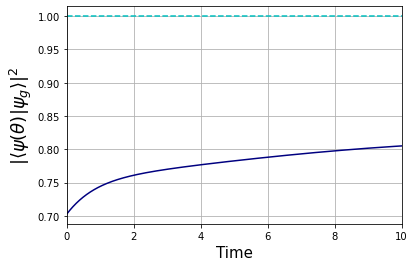

In [28]:
n = 1
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(1):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk])
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_3qutrits_M=0.1_N=2_comparison.pdf")

No handles with labels found to put in legend.


(0.0, 10.0)

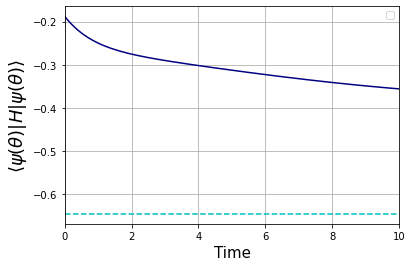

In [29]:
for kkk in range(1):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk])
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_comparison.pdf")

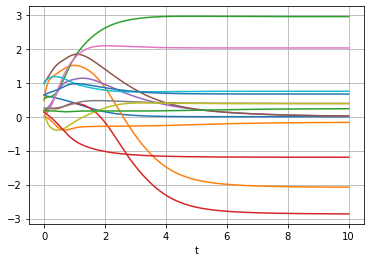

In [27]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [28]:
for i in range(coeff*N):
    print(Y[-1][i])

-0.0009822630236511927
-2.0773526708935393
2.9480469499510007
-2.864729471160893
0.018013947434421584
0.018293766962629833
2.024719767673083
0.39156328242486227
0.38360063620482215
0.7497325366621957
0.6668533985677328
-0.1685353591678328
0.23401062171479337
-1.1941919452995613


In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

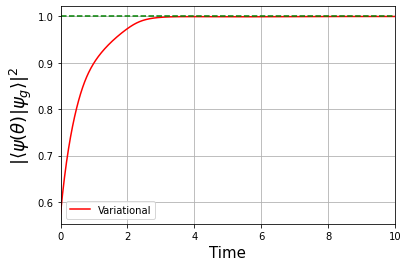

(0.0, 10.0)

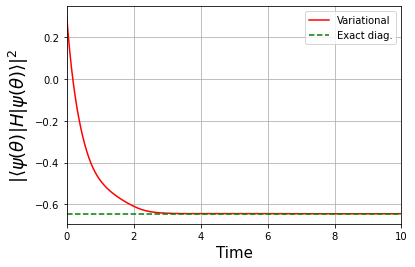

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
